In [40]:
from matplotlib import pyplot
from numpy import where
import pandas as pd 
import os 
import json
import numpy as np
import pylab as plt
import time
import zipfile
import seaborn as sns
import random

In [5]:
def unzipfile(filename):
    with zipfile.ZipFile(filename,"r") as zip_ref:
        zip_ref.extractall()

In [ ]:
# Unzip the files

# unzipfile("VeReMi_50400_54000_2022-9-11_19.12.56.zip")
unzipfile("VeReMi_54000_57600_2022-9-11_19.12.56.zip")
# unzipfile("VeReMi_57600_61200_2022-9-11_19.12.56.zip")

In [2]:
# Path for the datasets of the scenario 14:00-16:00

# path_1 = 'VeReMi_50400_54000_2022-9-11_19_12_56'
path_2 = 'VeReMi_54000_57600_2022-9-11_19_12_56'
# path_3 = 'VeReMi_57600_61200_2022-9-11_19_12_56'


In [3]:
# List the json files in each folder
list_of_files = []

# for root, dirs, files in os.walk(path_1):
#     for file in files:
#         list_of_files.append(os.path.join(root,file))

for root, dirs, files in os.walk(path_2):
    for file in files:
        list_of_files.append(os.path.join(root,file))
        
# for root, dirs, files in os.walk(path_3):
#     for file in files:
#         list_of_files.append(os.path.join(root,file))

In [4]:
list_of_files

['VeReMi_54000_57600_2022-9-11_19_12_56\\traceGroundTruthJSON-15.json',
 'VeReMi_54000_57600_2022-9-11_19_12_56\\traceJSON-10005-10003-A0-57500-15.json',
 'VeReMi_54000_57600_2022-9-11_19_12_56\\traceJSON-10011-10009-A13-57501-15.json',
 'VeReMi_54000_57600_2022-9-11_19_12_56\\traceJSON-10017-10015-A0-57501-15.json',
 'VeReMi_54000_57600_2022-9-11_19_12_56\\traceJSON-10023-10021-A0-57501-15.json',
 'VeReMi_54000_57600_2022-9-11_19_12_56\\traceJSON-10029-10027-A0-57511-15.json',
 'VeReMi_54000_57600_2022-9-11_19_12_56\\traceJSON-10035-10033-A13-57511-15.json',
 'VeReMi_54000_57600_2022-9-11_19_12_56\\traceJSON-10041-10039-A0-57522-15.json',
 'VeReMi_54000_57600_2022-9-11_19_12_56\\traceJSON-10047-10045-A0-57528-15.json',
 'VeReMi_54000_57600_2022-9-11_19_12_56\\traceJSON-10053-10051-A13-57530-15.json',
 'VeReMi_54000_57600_2022-9-11_19_12_56\\traceJSON-10059-10057-A0-57530-15.json',
 'VeReMi_54000_57600_2022-9-11_19_12_56\\traceJSON-10065-10063-A0-57530-15.json',
 'VeReMi_54000_57600_20

In [5]:
# # Each folder has one json file for the ground truth, we want to skip them
# list_of_files.remove('VeReMi_50400_54000_2022-9-11_19_12_56\\traceGroundTruthJSON-14.json')
list_of_files.remove('VeReMi_54000_57600_2022-9-11_19_12_56\\traceGroundTruthJSON-15.json')

In [6]:
# Calculate the number of json
nb_each_json = []

for index in range(len(list_of_files)):
    nb_each_json.append(sum(1 for line in open(list_of_files[index])))

len(list_of_files)

685

In [7]:
data = pd.DataFrame()
for index in range(len(list_of_files)):
    with open(list_of_files[index]) as f:
        # Read all the data in the files
        df = pd.DataFrame(json.loads(line) for line in f)
        # Read the following features from the name of json file (by splitting the file name)
        # labelRec: the label (0 normal, 13 (for this type of attack) attacker)
        # receiver: the receiver ID
        # moduleid: OMNeT++ module number, we don't need it now
        df['labelRec'] = list_of_files[index].rsplit('\\')[1].rsplit('-')[3].rsplit('A')[1]
        df['receiver'] = list_of_files[index].rsplit('\\')[1].rsplit('-')[1]
        # df['moduleid'] = list_of_files[index].rsplit('\\')[1].rsplit('-')[4]
        data = pd.concat([data,df])
    print(index)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [8]:
data.head()

,type,rcvTime,pos,pos_noise,spd,spd_noise,acl,acl_noise,hed,hed_noise,sendTime,sender,senderPseudo,messageID,labelRec,receiver
0,2,57500.000000,"[1364.2502336141008, 1288.4909054224877, 0.0]","[4.695924541634013, 4.479553841491734, 0.0]","[0.31949370588437215, -0.8833839302294603, 0.0]","[0.0007885166091199078, -0.0021802835166237745...","[0.7419881724749522, -2.0513971925618435, 0.0]","[0.0016795649617828991, 0.004648365087526581, ...","[0.33832632528772, -0.9410288505764889, 0.0]","[2.0136039534136367, 2.270985530780648, 0.0]",NaN,NaN,NaN,NaN,0,10005
1,3,57500.060431,"[1393.0355909671564, 1213.6295933806853, 0.0]","[3.412886167658555, 3.5086161530164546, 0.0]","[0.16897336761798612, -0.9737524445255518, 0.0]","[-4.743456748259832e-05, 0.0002733568985052635...","[0.3869957150512039, -2.2301267209000812, 0.0]","[0.00023329022457063944, 0.0005540816905585013...","[0.1708298304255435, -0.9853005475674821, 0.0]","[0.41814183308851083, 0.468761105995403, 0.0]",57500.060431,9993.0,1099935.0,25189779.0,0,10005
2,3,57500.102975,"[1367.7244205822285, 1096.6305382158603, 0.0]","[4.3178877259788395, 4.6028652878682506, 0.0]","[-0.45633748025104454, -0.8737277809371733, 0.0]","[0.0014137470328284408, 0.0027067727850650126,...","[-1.1819584363929563, -2.263096426403208, 0.0]","[0.004511628680080489, 0.00580465443231706, 0.0]","[-0.46538968567407135, -0.8851058922344767, 0.0]","[10.764231378754896, 11.223028217788116, 0.0]",57500.102975,9999.0,1099995.0,25189973.0,0,10005
3,3,57500.310436,"[1393.0355909671564, 1213.6295933806853, 0.0]","[3.412886167658555, 3.5086161530164546, 0.0]","[0.16897336761798612, -0.9737524445255518, 0.0]","[-4.743456748259832e-05, 0.0002733568985052635...","[0.3869957150512039, -2.2301267209000812, 0.0]","[0.00023329022457063944, 0.0005540816905585013...","[0.1708298304255435, -0.9853005475674821, 0.0]","[0.41814183308851083, 0.468761105995403, 0.0]",57500.310436,9993.0,1099935.0,25190367.0,0,10005
4,3,57500.560433,"[1393.0355909671564, 1213.6295933806853, 0.0]","[3.412886167658555, 3.5086161530164546, 0.0]","[0.16897336761798612, -0.9737524445255518, 0.0]","[-4.743456748259832e-05, 0.0002733568985052635...","[0.3869957150512039, -2.2301267209000812, 0.0]","[0.00023329022457063944, 0.0005540816905585013...","[0.1708298304255435, -0.9853005475674821, 0.0]","[0.41814183308851083, 0.468761105995403, 0.0]",57500.560433,9993.0,1099935.0,25190914.0,0,10005


In [9]:
# Pos, Spd, Acl, Hed, and their noise features have three axis: x,y,z. 
# This function separates their x and y axis (z is always 0 for all, so we did not consider them.)
def clean_dataset(l, droped_features, data):
    for t in l:
        data[t + '_x'] = None
        data[t + '_y'] = None

    for j in l:
        data[j + '_x'] = data[j].apply(lambda row: row[0]) 
        data[j + '_y'] = data[j].apply(lambda row: row[1])
    data = data.drop(columns=l,axis=1)
    data.drop_duplicates(inplace=True)
    data.drop(columns= droped_features,inplace=True)
    return data


In [10]:
# The features who needs to be separated for the different axis
l = ['pos', 'pos_noise', 'spd', 'spd_noise', 'acl', 'acl_noise', 'hed', 'hed_noise']

In [22]:
bsm = data[data.type==3]

In [23]:
# Using clean_dataset function, separate the features in l to their x and y axis
droped_features = []
bsm = clean_dataset(l, droped_features, bsm)

C:\Users\Erena\AppData\Local\Temp\ipykernel_2500\698515855.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[t + '_x'] = None
C:\Users\Erena\AppData\Local\Temp\ipykernel_2500\698515855.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[t + '_y'] = None
C:\Users\Erena\AppData\Local\Temp\ipykernel_2500\698515855.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [24]:
bsm.head()

,type,rcvTime,sendTime,sender,senderPseudo,messageID,labelRec,receiver,pos_x,pos_y,...,spd_noise_x,spd_noise_y,acl_x,acl_y,acl_noise_x,acl_noise_y,hed_x,hed_y,hed_noise_x,hed_noise_y
1,3,57500.060431,57500.060431,9993.0,1099935.0,25189779.0,0,10005,1393.035591,1213.629593,...,-0.000047,0.000273,0.386996,-2.230127,0.000233,0.000554,0.17083,-0.985301,0.418142,0.468761
2,3,57500.102975,57500.102975,9999.0,1099995.0,25189973.0,0,10005,1367.724421,1096.630538,...,0.001414,0.002707,-1.181958,-2.263096,0.004512,0.005805,-0.46539,-0.885106,10.764231,11.223028
3,3,57500.310436,57500.310436,9993.0,1099935.0,25190367.0,0,10005,1393.035591,1213.629593,...,-0.000047,0.000273,0.386996,-2.230127,0.000233,0.000554,0.17083,-0.985301,0.418142,0.468761
4,3,57500.560433,57500.560433,9993.0,1099935.0,25190914.0,0,10005,1393.035591,1213.629593,...,-0.000047,0.000273,0.386996,-2.230127,0.000233,0.000554,0.17083,-0.985301,0.418142,0.468761
5,3,57500.810438,57500.810438,9993.0,1099935.0,25191671.0,0,10005,1393.035591,1213.629593,...,-0.000047,0.000273,0.386996,-2.230127,0.000233,0.000554,0.17083,-0.985301,0.418142,0.468761


In [14]:
bsm.dtypes

type              int64
rcvTime         float64
sendTime        float64
sender          float64
senderPseudo    float64
messageID       float64
labelRec         object
receiver         object
pos_x           float64
pos_y           float64
pos_noise_x     float64
pos_noise_y     float64
spd_x           float64
spd_y           float64
spd_noise_x     float64
spd_noise_y     float64
acl_x           float64
acl_y           float64
acl_noise_x     float64
acl_noise_y     float64
hed_x           float64
hed_y           float64
hed_noise_x     float64
hed_noise_y     float64
dtype: object

In [25]:
bsm['receiver'] = bsm['receiver'].astype("float64")
# bsm['sender'] = bsm['sender'].astype("float64")
bsm['labelRec'] = bsm['labelRec'].astype("int64")

bsm.head()



,type,rcvTime,sendTime,sender,senderPseudo,messageID,labelRec,receiver,pos_x,pos_y,...,spd_noise_x,spd_noise_y,acl_x,acl_y,acl_noise_x,acl_noise_y,hed_x,hed_y,hed_noise_x,hed_noise_y
1,3,57500.060431,57500.060431,9993.0,1099935.0,25189779.0,0,10005.0,1393.035591,1213.629593,...,-0.000047,0.000273,0.386996,-2.230127,0.000233,0.000554,0.17083,-0.985301,0.418142,0.468761
2,3,57500.102975,57500.102975,9999.0,1099995.0,25189973.0,0,10005.0,1367.724421,1096.630538,...,0.001414,0.002707,-1.181958,-2.263096,0.004512,0.005805,-0.46539,-0.885106,10.764231,11.223028
3,3,57500.310436,57500.310436,9993.0,1099935.0,25190367.0,0,10005.0,1393.035591,1213.629593,...,-0.000047,0.000273,0.386996,-2.230127,0.000233,0.000554,0.17083,-0.985301,0.418142,0.468761
4,3,57500.560433,57500.560433,9993.0,1099935.0,25190914.0,0,10005.0,1393.035591,1213.629593,...,-0.000047,0.000273,0.386996,-2.230127,0.000233,0.000554,0.17083,-0.985301,0.418142,0.468761
5,3,57500.810438,57500.810438,9993.0,1099935.0,25191671.0,0,10005.0,1393.035591,1213.629593,...,-0.000047,0.000273,0.386996,-2.230127,0.000233,0.000554,0.17083,-0.985301,0.418142,0.468761


In [26]:
# Receiver - Sender matching

labelization = bsm[['receiver','labelRec']]
labelization.drop_duplicates(inplace=True)
bsm = bsm.drop(columns=['receiver','labelRec'], axis = 1)

C:\Users\Erena\AppData\Local\Temp\ipykernel_2500\2341780072.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labelization.drop_duplicates(inplace=True)


In [27]:
bsm = pd.merge(bsm, labelization ,left_on='sender',right_on='receiver',how='left')
bsm.rename(columns={'labelRec':'label'},inplace=True)
bsm = bsm.drop(columns=['receiver'], axis = 1)

In [28]:
bsm = bsm.dropna()
bsm.head()

,type,rcvTime,sendTime,sender,senderPseudo,messageID,pos_x,pos_y,pos_noise_x,pos_noise_y,...,spd_noise_y,acl_x,acl_y,acl_noise_x,acl_noise_y,hed_x,hed_y,hed_noise_x,hed_noise_y,label
0,3,57500.060431,57500.060431,9993.0,1099935.0,25189779.0,1393.035591,1213.629593,3.412886,3.508616,...,0.000273,0.386996,-2.230127,0.000233,0.000554,0.17083,-0.985301,0.418142,0.468761,13.0
1,3,57500.102975,57500.102975,9999.0,1099995.0,25189973.0,1367.724421,1096.630538,4.317888,4.602865,...,0.002707,-1.181958,-2.263096,0.004512,0.005805,-0.46539,-0.885106,10.764231,11.223028,0.0
2,3,57500.310436,57500.310436,9993.0,1099935.0,25190367.0,1393.035591,1213.629593,3.412886,3.508616,...,0.000273,0.386996,-2.230127,0.000233,0.000554,0.17083,-0.985301,0.418142,0.468761,13.0
3,3,57500.560433,57500.560433,9993.0,1099935.0,25190914.0,1393.035591,1213.629593,3.412886,3.508616,...,0.000273,0.386996,-2.230127,0.000233,0.000554,0.17083,-0.985301,0.418142,0.468761,13.0
4,3,57500.810438,57500.810438,9993.0,1099935.0,25191671.0,1393.035591,1213.629593,3.412886,3.508616,...,0.000273,0.386996,-2.230127,0.000233,0.000554,0.17083,-0.985301,0.418142,0.468761,13.0


In [29]:
bsm.describe()

,type,rcvTime,sendTime,sender,senderPseudo,messageID,pos_x,pos_y,pos_noise_x,pos_noise_y,...,spd_noise_y,acl_x,acl_y,acl_noise_x,acl_noise_y,hed_x,hed_y,hed_noise_x,hed_noise_y,label
count,372541.0,372541.000000,372541.000000,372541.000000,3.725410e+05,3.725410e+05,372541.000000,372541.000000,372541.000000,372541.000000,...,372541.000000,372541.000000,372541.000000,372541.000000,372541.000000,372541.000000,372541.000000,372541.000000,372541.000000,372541.000000
mean,3.0,56025.443472,56025.443472,8119.108412,1.229891e+06,2.119536e+07,479.823493,616.757701,3.982880,3.984817,...,0.000629,-0.006124,-0.013936,0.000747,0.000913,-0.091964,0.092864,13.146682,12.584982,7.397390
std,0.0,988.809947,988.809947,1126.762037,1.149806e+06,2.463859e+06,367.754303,290.371536,0.605271,0.609487,...,0.012259,0.926970,1.163778,0.002474,0.002514,0.638861,0.758142,14.395125,15.133712,6.437764
min,3.0,54004.015620,54004.015620,6033.000000,1.060335e+06,1.657714e+07,24.718157,24.328181,2.672641,2.640920,...,-0.068715,-4.499086,-4.499703,0.000000,0.000000,-1.000000,-1.000000,0.001070,0.001091,0.000000
25%,3.0,55475.587725,55475.587725,7335.000000,1.073355e+06,1.927511e+07,196.414089,381.224209,3.472579,3.475879,...,-0.003252,-0.199059,-0.251834,0.000005,0.000006,-0.727873,-0.695127,3.600698,2.801934,0.000000
50%,3.0,55887.421309,55887.421309,7977.000000,1.079775e+06,2.100338e+07,265.426416,619.779086,3.940438,3.937658,...,0.000000,0.000034,0.000056,0.000056,0.000060,-0.048989,0.169430,8.614507,6.900201,13.000000
75%,3.0,57005.883271,57005.883271,9153.000000,1.091535e+06,2.343309e+07,771.192607,889.365687,4.526825,4.529718,...,0.004912,0.151458,0.261149,0.000369,0.000639,0.125523,0.988151,16.863655,16.066495,13.000000
max,3.0,57599.973586,57599.973586,10137.000000,1.010138e+07,2.551337e+07,1395.851040,1359.650715,5.588711,5.486081,...,0.066301,4.501038,4.495619,0.086270,0.088367,1.000000,1.000000,101.405995,91.852096,13.000000


In [30]:
bsm.columns

Index(['type', 'rcvTime', 'sendTime', 'sender', 'senderPseudo', 'messageID',
       'pos_x', 'pos_y', 'pos_noise_x', 'pos_noise_y', 'spd_x', 'spd_y',
       'spd_noise_x', 'spd_noise_y', 'acl_x', 'acl_y', 'acl_noise_x',
       'acl_noise_y', 'hed_x', 'hed_y', 'hed_noise_x', 'hed_noise_y', 'label'],
      dtype='object')

In [31]:
bsm.dtypes

type              int64
rcvTime         float64
sendTime        float64
sender          float64
senderPseudo    float64
messageID       float64
pos_x           float64
pos_y           float64
pos_noise_x     float64
pos_noise_y     float64
spd_x           float64
spd_y           float64
spd_noise_x     float64
spd_noise_y     float64
acl_x           float64
acl_y           float64
acl_noise_x     float64
acl_noise_y     float64
hed_x           float64
hed_y           float64
hed_noise_x     float64
hed_noise_y     float64
label           float64
dtype: object

In [32]:
bsm['label'] = bsm['label'].astype("int64")

In [33]:
# Number of lines in the dataset
len(bsm)

372541

In [34]:
# Number of normal vehicles (0) and number of attackers (13) in the dataset
bsm.label.value_counts()

13    211987
0     160554
Name: label, dtype: int64

# Classification

In [37]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from collections import Counter

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


pd.set_option("display.max_columns", None)

In [60]:
def classification_attack(method,veremi):
       
    # Our labels are 0 or 13; we need 0-1 for classification algorithms. Convert 13 to 1
    veremi['label'] = veremi['label'].replace(13,1)
    
    # Create feature set X and label set y 
    y = veremi['label']
    X = veremi.drop(columns=['label','type', 'rcvTime', 'sendTime', 'sender', 'senderPseudo', 'messageID'], axis=1)
    
    # Data split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0, stratify=y)
    
   # random.seed(1234)
             
    if method=='RF':
        # Random Forest
        rf = RandomForestClassifier(n_estimators=50, bootstrap=True, random_state=0)

        start = time.time()
        rf.fit(X_train, y_train)
        timefit = time.time() - start

        start = time.time()
        y_pred = rf.predict(X_test)
        timepred = time.time() - start
        
  #  random.seed(1234)
    
    elif method=='Xgboost':
        # XGBoost
        xgb = XGBClassifier()

        start = time.time()
        xgb.fit(X_train,y_train)
        timefit = time.time() - start

        start = time.time()
        y_pred = xgb.predict(X_test)
        timepred = time.time() - start

           
              
   
       
    report = classification_report(y_test,y_pred,output_dict=True)

    return(report['accuracy'], report['weighted avg']['precision'], report['weighted avg']['recall'], 
          report['weighted avg']['f1-score'], timefit, timepred)


# Outputs and Stockage

In [61]:
results = pd.DataFrame(index=['Xgboost','RF'],
                       columns=['Acc','Pre','Rec','F1s','TimeFit','TimePred'])

In [62]:
results.xs('Xgboost')[:] = classification_attack('Xgboost',bsm)
print(results)
results.xs('RF')[:] = classification_attack('RF',bsm)
print(results)

# results.to_excel('results.xlsx')

              Acc       Pre       Rec       F1s    TimeFit  TimePred
Xgboost  0.944758  0.944862  0.944758  0.944648  21.747592  0.109881
RF            NaN       NaN       NaN       NaN        NaN       NaN
              Acc       Pre       Rec       F1s     TimeFit  TimePred
Xgboost  0.944758  0.944862  0.944758  0.944648   21.747592  0.109881
RF       0.998752  0.998752  0.998752  0.998752  165.348923  1.887658


In [59]:
results.xs('Xgboost')[:] = classification_attack('Xgboost',bsm)
print(results)
results.xs('RF')[:] = classification_attack('RF',bsm)
print(results)

# results.to_excel('results.xlsx')

              Acc       Pre       Rec       F1s     TimeFit  TimePred
Xgboost  0.944758  0.944862  0.944758  0.944648   29.181778  0.124998
RF       0.998752  0.998752  0.998752  0.998752  171.934576  1.970003
              Acc       Pre       Rec       F1s     TimeFit  TimePred
Xgboost  0.944758  0.944862  0.944758  0.944648   29.181778  0.124998
RF       0.998752  0.998752  0.998752  0.998752  139.750432  1.676692


In [169]:
results

,Acc,Pre,Rec,F1s,TimeFit,TimePred
Xgboost,0.944758,0.944862,0.944758,0.944648,15.504324,0.075347
RF,0.998779,0.998779,0.998779,0.998779,114.261511,1.303521


# Clustering

In [95]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

In [170]:
def clustering_attack(method,veremi):
       
    # Our labels are 0 or 13; we need 0-1 for classification algorithms. Convert 13 to 1
    veremi['label'] = veremi['label'].replace(13,1)
    
    # Create feature set X and label set y 
    y = veremi['label']
    X = veremi.drop(columns=['label','type', 'rcvTime', 'sendTime', 'sender', 'senderPseudo', 'messageID'], axis=1)
    
    # Data split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0, stratify=y)
    
    scaler = StandardScaler()
    scaled_X_train = scaler.fit_transform(X_train)
    scaled_X_test = scaler.fit_transform(X_test)
             
    if method=='kMeans':
        # k-Means
        kmeans = KMeans(n_clusters=2)
        
        start = time.time()
        kmeans.fit(scaled_X_train)
        timefit = time.time() - start

        start = time.time()
        y_pred = kmeans.predict(scaled_X_test)
        timepred = time.time() - start
    
    elif method=='GMM':
        # Gaussian Mixture Model
        gmm = GaussianMixture(n_components=2)

        start = time.time()
        gmm.fit(scaled_X_train)
        timefit = time.time() - start

        start = time.time()
        y_pred = gmm.predict(scaled_X_test)
        timepred = time.time() - start

           
              
   
       
    report = classification_report(y_test,y_pred,output_dict=True)

    return(report['accuracy'], report['weighted avg']['precision'], report['weighted avg']['recall'], 
          report['weighted avg']['f1-score'], timefit, timepred)


In [171]:
results_cluster = pd.DataFrame(index=['kMeans','GMM'],
                       columns=['Acc','Pre','Rec','F1s','TimeFit','TimePred'])

In [172]:
results_cluster.xs('kMeans')[:] = clustering_attack('kMeans',bsm)
print(results_cluster)
results_cluster.xs('GMM')[:] = clustering_attack('GMM',bsm)
print(results_cluster)

results_cluster.to_excel('results_cluster.xlsx')

C:\Users\Erena\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


             Acc       Pre       Rec      F1s   TimeFit  TimePred
kMeans  0.483794  0.492539  0.483794  0.48625  2.202263  0.055901
GMM          NaN       NaN       NaN      NaN       NaN       NaN
             Acc       Pre       Rec       F1s    TimeFit  TimePred
kMeans  0.483794  0.492539  0.483794   0.48625   2.202263  0.055901
GMM     0.507455  0.488276  0.507455  0.490384  12.959008  0.039907


# Visualization

In [ ]:
bsm['label'] = bsm['label'].replace(13,1)
y = bsm['label']
X = bsm.drop(columns=['label','type', 'rcvTime', 'sendTime', 'sender', 'senderPseudo', 'messageID'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0, stratify=y)

In [173]:

xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)

Text(45.722222222222214, 0.5, 'True Labels')

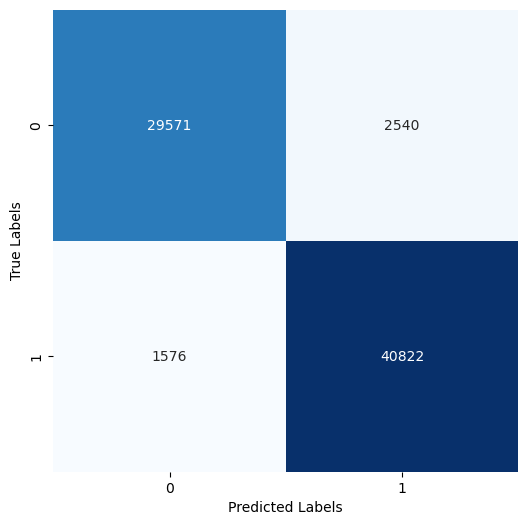

In [174]:

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(6,6)) 
sns.heatmap(cm, annot=True, cbar=False, cmap='Blues', fmt='.0f')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

In [175]:

xgb = XGBClassifier()

eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["auc","error"]

xgb.fit(X_train, y_train, eval_set=eval_set, eval_metric=eval_metric, verbose=True)

C:\Users\Erena\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.76080	validation_0-error:0.31200	validation_1-auc:0.76022	validation_1-error:0.31144
[1]	validation_0-auc:0.79438	validation_0-error:0.29121	validation_1-auc:0.79419	validation_1-error:0.29105
[2]	validation_0-auc:0.81312	validation_0-error:0.27003	validation_1-auc:0.81271	validation_1-error:0.27101
[3]	validation_0-auc:0.83037	validation_0-error:0.25253	validation_1-auc:0.82984	validation_1-error:0.25312
[4]	validation_0-auc:0.83762	validation_0-error:0.24943	validation_1-auc:0.83738	validation_1-error:0.24986
[5]	validation_0-auc:0.83929	validation_0-error:0.25042	validation_1-auc:0.83915	validation_1-error:0.24950
[6]	validation_0-auc:0.86602	validation_0-error:0.22085	validation_1-auc:0.86607	validation_1-error:0.22078
[7]	validation_0-auc:0.88009	validation_0-error:0.20782	validation_1-auc:0.88030	validation_1-error:0.20728
[8]	validation_0-auc:0.88556	validation_0-error:0.20219	validation_1-auc:0.88541	validation_1-error:0.20242
[9]	validation_0-auc:0.88747

[76]	validation_0-auc:0.98420	validation_0-error:0.06552	validation_1-auc:0.98185	validation_1-error:0.06971
[77]	validation_0-auc:0.98446	validation_0-error:0.06473	validation_1-auc:0.98212	validation_1-error:0.06908
[78]	validation_0-auc:0.98486	validation_0-error:0.06413	validation_1-auc:0.98256	validation_1-error:0.06815
[79]	validation_0-auc:0.98513	validation_0-error:0.06312	validation_1-auc:0.98282	validation_1-error:0.06748
[80]	validation_0-auc:0.98537	validation_0-error:0.06220	validation_1-auc:0.98309	validation_1-error:0.06661
[81]	validation_0-auc:0.98565	validation_0-error:0.06140	validation_1-auc:0.98338	validation_1-error:0.06602
[82]	validation_0-auc:0.98581	validation_0-error:0.06118	validation_1-auc:0.98359	validation_1-error:0.06552
[83]	validation_0-auc:0.98637	validation_0-error:0.06002	validation_1-auc:0.98412	validation_1-error:0.06437
[84]	validation_0-auc:0.98681	validation_0-error:0.05889	validation_1-auc:0.98458	validation_1-error:0.06325
[85]	validation_0-a

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [176]:
results = xgb.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

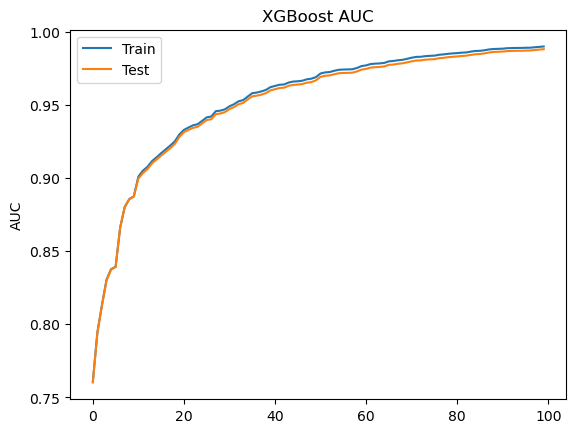

In [177]:
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
pyplot.ylabel('AUC')
pyplot.title('XGBoost AUC')
pyplot.show()

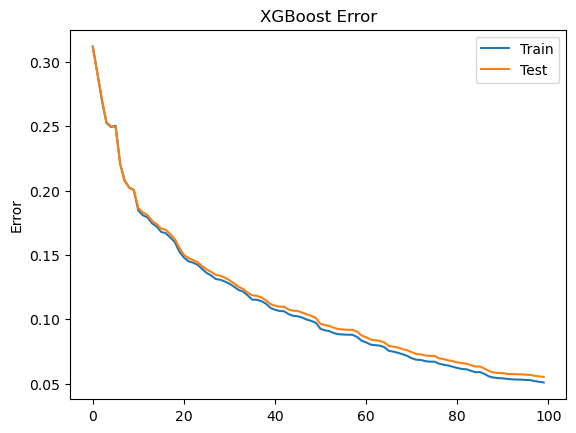

In [178]:
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Error')
pyplot.title('XGBoost Error')
pyplot.show()

In [179]:
# XGBoost uses probability prediction to compute AUC. So you should use predict_proba() instead of predict():

# get probabilities for positive class
predictions = xgb.predict_proba(X_test)[:,1]
roc = roc_auc_score(y_test, predictions)
print("AUC: %.4f%% " % (roc * 100)) 

AUC: 98.8036% 


## Trials